# Homework 4 - Applied Machine Learning

This notebook corresponds the Homework 4. Firsly, we are going to explore and clean the data we have. Then, we are going to process some Machine Learning on these data.

We are going to work with the data from the CrowdstormingDataJuly1st.csv file, which represent all players playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees that these players played under in their professional career. Each row of the tables is a dyad containing information about a player given by a specific referee (for example the number of yellow cards given by this referee to the player) and also some statistics about racial bias in the referee's home country.


Our objectif is to determine the skin color of a player depending on its characteristics. In the first part, we are going to do some supervised machine learning by training a classifier. The second task will consist in processing some unsuppervised machine learning by clustering the data. 

### Imports

We start with the usual imports

In [66]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

### Uploading the data

In [67]:
filename = 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

# 0. Data Exploration and cleaning

Let's observe our data structure. First we see that we have 146028 initial rows with 28 parameters each.

In [68]:
df.shape

(146028, 28)

The 10 first parameters of the lines 100 to 105 are shown bellow. (We look at the parameters in two tables for better vizualisation)

In [69]:
df.head()
df.ix[100:105,:12]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats
100,fousseni-diawara,Fousseni Diawara,AC Ajaccio,France,28.08.1980,183.0,71.0,NaN,1,0,1,0
101,franck-signorino,Franck Signorino,Stade Reims,France,19.09.1981,173.0,69.0,Left Fullback,2,2,0,0
102,francois-marque,François Marque,SC Bastia,France,31.07.1983,187.0,85.0,Center Back,2,0,1,1
103,frederic-duplus,Frédéric Duplus,FC Sochaux,France,07.04.1990,175.0,66.0,Left Fullback,1,0,1,0
104,frederic-sammaritano,Frédéric Sammaritano,AC Ajaccio,France,23.03.1986,162.0,61.0,NaN,6,1,3,2
105,gael-angoula,Gaël Angoula,SC Bastia,France,18.07.1982,177.0,75.0,NaN,1,1,0,0


In [70]:
df.ix[100:105,12:]

,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
100,0,0,0,0,18905.jpg,0.75,1.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
101,0,0,0,0,11653.jpg,0.00,0.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
102,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
103,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
104,0,0,0,0,124957.jpg,0.25,0.25,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
105,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


The parameters *rater1* and *rater2* are skin rating of the player photo given by two differents raters (5-point scale ranging from “very light skin” (0.00 value) to “very dark skin” (1.00 value)).

We observe that there are some NaN values for rater1 and rater2. In these cases, no picture was available for this player. The correlation seems obvious because the raters used the player photo to determine its skin color, but let's verify it:

In [71]:
notRatedAtAll = (df.rater1.isnull() & df.rater2.isnull())
partiallyRated = (df.rater1.isnull() | df.rater2.isnull())
photoMissing = df.photoID.isnull()

print("Both rates missing iff one rate missing: {}".format( all(notRatedAtAll == partiallyRated)))

print("Photo missing iff rating missing: {}".format( all(notRatedAtAll == photoMissing)))

Both rates missing iff one rate missing: True
Photo missing iff rating missing: True


Our objectif is to determine the skin color of a player depending on its characteristics with the use of a classifier. Therefore, the players for which we don't have any information on their skin color will not be interesting for us. We can therefore drop theses specific rows.

Let's check how many rows is concerned by this lack of information

In [72]:
(df.photoID.isnull()).sum()

21407

In [73]:
df.shape

(146028, 28)

In [74]:
21407/146028*100

14.659517352836444

Therefore, more or less 14.7% of our data are concerned by this lack, but we don't have any other choice that drop them because theses rows do not bring us more information.

In [75]:
df = df[(df.photoID.isnull() == False)]
df.shape

(124621, 28)

Let's check if we correctly removed all the NaNs for the rater1 and rater2 parameters

In [76]:
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

Note also that we don't need the the parameter photoID anymore, so we can drop it:

In [77]:
df = df.drop(['photoID'], axis=1)

Here, we have an other problem. For many entries (28907, i.e 23%), the two raters do not give us similar result.

In [78]:
(df.rater1 != df.rater2).sum()

28907

In [79]:
28907 / 124621 * 100

23.195930059941745

In order to counter this issue, we can take the euclidian mean value between the two rates of each row. Let's observe that the mean value representes correctly the situation. Let's calculate the mean rate for each column and the difference between the two rates to see if sometimes the raters give opposite results.

In [80]:
ratingsDf = df[['rater1', 'rater2']]

# Computing the mean
ratingsDf['avgRate'] = (ratingsDf['rater1'] + ratingsDf['rater2']) / 2

# Computing the difference
ratingsDf['diffRate12'] = ratingsDf['rater1'] - ratingsDf['rater2']

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


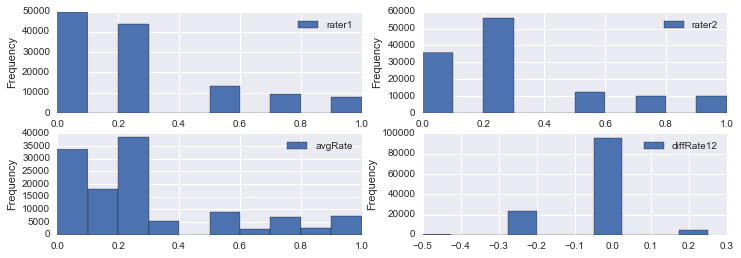

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

ratingsDf[['rater1']].plot.hist(ax=axes[0][0])
ratingsDf[['rater2']].plot.hist(ax=axes[0][1])
ratingsDf[['avgRate']].plot.hist(ax=axes[1][0])
ratingsDf[['diffRate12']].plot.hist(ax=axes[1][1]);

Firstly, we observe that most of the time, when the raters give different result, their values are only separated by 0.25, which means that the computing the mean rates should be consitent to represent the data. This is confirmed if we take a look at the average rate histogram. It looks very similar to the two rates histogram. In order to confirm that, let's get a look at the correlation matrix:

In [82]:
ratingsDf.corr()

,rater1,rater2,avgRate,diffRate12
rater1,1.000000,0.923467,0.980837,0.215314
rater2,0.923467,1.000000,0.980523,-0.175843
avgRate,0.980837,0.980523,1.000000,0.020925
diffRate12,0.215314,-0.175843,0.020925,1.000000


We see that the correlation of the *avgRate* is very high for both raters. Therefore, let's replace rater1 and rater2 values by their mean in our data and use it for further analysis.

In [83]:
# We create a new column in our data set with the mean value
df['avgRate'] = ratingsDf[['avgRate']]

# Remove the columns of rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [84]:
df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,avgRate
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


We are interested by determing the skin color of each player. Therefore, we need to regroup the entries by player, applying the mean on each values.

In [85]:
df_by_player = df.groupby("playerShort")
df_players = df_by_player.agg(np.mean)
df_players.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,avgRate
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065,0.125
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993,0.125
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032,0.250
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522,0.000
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296,0.250


In this case, the attributes *reNum*, *refCountry*, *nIAT*, *nExp* do not make any sense, and we can drop them.

In [86]:
df_players = df_players.drop(['refNum', 'refCountry', 'nIAT', 'nExp'], axis=1)

In [87]:
df_players.shape

(1585, 15)

We observe that we have a total of 1585 football players in our data. Note also that we still have some entries filled with NaN. Let's drop them.

In [88]:
df_players.isnull().any()

height          True
weight          True
games          False
victories      False
ties           False
defeats        False
goals          False
yellowCards    False
yellowReds     False
redCards       False
meanIAT        False
seIAT          False
meanExp        False
seExp          False
avgRate        False
dtype: bool

In [89]:
df_players = df_players[(df_players.height.isnull() == False)]
df_players = df_players[(df_players.weight.isnull() == False)]

In [90]:
df_players.isnull().any()

height         False
weight         False
games          False
victories      False
ties           False
defeats        False
goals          False
yellowCards    False
yellowReds     False
redCards       False
meanIAT        False
seIAT          False
meanExp        False
seExp          False
avgRate        False
dtype: bool

In [91]:
df_players.shape

(1564, 15)

We observe now that we have 1564 players left in our *cleaned* data set.

# 1. Maching Learning - Random Forest

We are going to use 